# Training the Neural Network

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="diagrams/nn.png")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle5 as pickle
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
seed = 663
np.random.seed(seed)
torch.manual_seed(seed)

# Loading Files

In [3]:
train_file = "munged_data/train.pk"
test_file = "munged_data/validation.pk"
trained_model_file = "models/trained_model.pk"
train_df = pd.read_pickle(train_file)
train_df = train_df.sample(frac=1)
test_df = pd.read_pickle(test_file)
test_df = test_df.sample(frac=1)

In [4]:
def transform_data_for_processing(df, num_pca, is_train):
    # transform arrival_date from datetime to int
    df["arrival_date"] = df["arrival_date"].astype("int64")
    # explode the vec_product_details column 
    vecs = df["vec_product_details"].explode().to_frame()
    vecs["obs_id"] = vecs.groupby(level=0).cumcount()
    vecs = vecs.pivot(columns="obs_id", values="vec_product_details").fillna(0)
    vecs = vecs.add_prefix("vec_product_details_")
    # put exploded data and rest together
    df = pd.concat([df, vecs], axis=1)
    df.drop(columns=["vec_product_details"], inplace=True)
    X = df.copy(deep=True)
    X.drop(columns=["country_of_origin_labels"], inplace=True)
    y = df.copy(deep=True)
    y = y[["country_of_origin_labels"]]
    # scale features for PCA
    standard_scaler = StandardScaler()
    if is_train:
        standard_scaler.fit(X)
        pickle.dump(standard_scaler, open("models/standard_scaler_pca.pk", "wb"))
    standard_scaler = pickle.load(open("models/standard_scaler_pca.pk", "rb"))
    X = standard_scaler.transform(X)
    # pca
    pca = PCA(n_components=num_pca)
    if is_train:
        pca.fit(X, y)
        pickle.dump(pca, open("models/pca.pk", "wb"))
    pca = pickle.load(open("models/pca.pk", "rb"))
    X = pca.transform(X)
    X =  torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y.to_numpy(), dtype=torch.float32).reshape(-1, 1)
    y = torch.flatten(y)
    y = y.type(torch.LongTensor)
    return X, y

In [5]:
# loan train and test data for torch processing
X_train, y_train = transform_data_for_processing(train_df, num_pca=280, is_train=True)
X_test, y_test = transform_data_for_processing(test_df, num_pca=280, is_train=False)

In [6]:
# sanity check
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
num_features_train = X_train.shape[1]
num_instances_train = X_train.shape[0]
num_features_test = X_test.shape[1]
num_instances_test = y_test.shape[0]
num_targets = len(train_df["country_of_origin_labels"].unique())
print(f"num_targets: {num_targets}")

X_train: torch.Size([130485, 280])
y_train: torch.Size([130485])
X_test: torch.Size([43608, 280])
y_test: torch.Size([43608])
num_targets: 60


In [7]:
class MLP(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()
        self.linear1 = nn.Linear(num_features, 120, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(120, num_targets, bias=True)
        # don't need softmax, since using cross-entropy loss

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [8]:
def get_accuracy(model, X, y, test_batch_size=5000):
    model.eval()
    test_loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=test_batch_size)
    accuracies = []
    for X_batch, y_batch in test_loader:
        y_hat = model(X_batch)
        acc = (torch.argmax(y_hat, 1) == y_batch).float().mean()
        accuracies.append(float(acc))
    return sum(accuracies)/len(accuracies)

In [9]:
def gradient_descent(model, X_train, y_train, X_test, y_test, batch_size=64, lr=0.1, weight_decay=0.01, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=batch_size)
    train_accs, test_accs, avg_loss, epochs, losses = [], [], [], [], []

    # train model
    for epoch in range(num_epochs):
        for X_batch, y_batch in iter(loader):
            y_hat = model(X_batch)
            loss = criterion(y_hat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(float(loss)/batch_size) 

        # evaluate model
        train_acc = get_accuracy(model, X_train, y_train)
        train_accs.append(train_acc)
        test_acc = get_accuracy(model, X_test, y_test)
        test_accs.append(test_acc)
        epochs.append(epoch)
        avg_loss.append(sum(losses)/len(losses))
        print(f"Epoch: {epoch} => avg train acc: {sum(train_accs)/len(train_accs)} | avg test acc: {sum(test_accs)/len(test_accs)}")

    # plot loss
    loss_df = pd.DataFrame({
        "epochs": epochs,
        "loss": avg_loss
    })
    loss_df.head()
    sns.lineplot(x="epochs", y="loss", data=loss_df)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, lr))
    plt.show()

    # plot acc
    acc_df = pd.DataFrame({
        "epochs": epochs,
        "train acc": train_accs,
        "test acc": test_accs
    })
    sns.lineplot(x="epochs", y="value", hue="variable", data=pd.melt(acc_df, ["epochs"]))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.ylabel("accuracy")
    plt.legend(loc='best')
    plt.show()
    return model

Epoch: 0 => avg train acc: 0.9286981335392704 | avg test acc: 0.9223670363426208
Epoch: 1 => avg train acc: 0.9338223768605126 | avg test acc: 0.9271478719181485
Epoch: 2 => avg train acc: 0.9374915383480213 | avg test acc: 0.9296258246457135
Epoch: 3 => avg train acc: 0.9395741323630016 | avg test acc: 0.9314961615535948
Epoch: 4 => avg train acc: 0.9410853460982995 | avg test acc: 0.9328732742203606
Epoch: 5 => avg train acc: 0.9422832381578141 | avg test acc: 0.9337968583460207
Epoch: 6 => avg train acc: 0.9434223966623742 | avg test acc: 0.9346091681056553
Epoch: 7 => avg train acc: 0.9442534656436357 | avg test acc: 0.935377170642217
Epoch: 8 => avg train acc: 0.9449369490391926 | avg test acc: 0.935928507351581
Epoch: 9 => avg train acc: 0.945658725500107 | avg test acc: 0.9364588836828867
Epoch: 10 => avg train acc: 0.9461557162731186 | avg test acc: 0.9368479215737544
Epoch: 11 => avg train acc: 0.9468329841340032 | avg test acc: 0.93734989784382
Epoch: 12 => avg train acc: 0.9

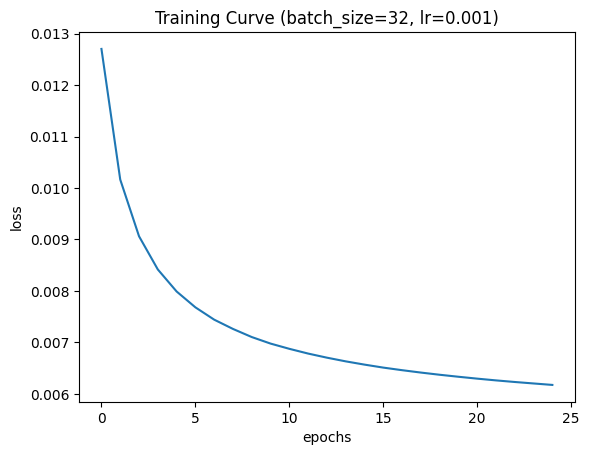

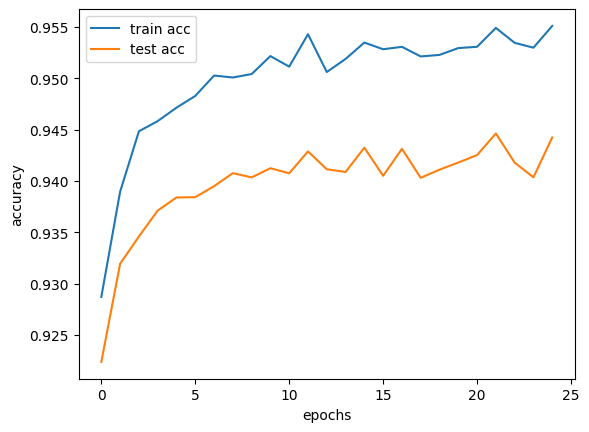

In [15]:
model = MLP(num_features_train, num_targets)
model = gradient_descent(model, X_train, y_train, X_test, y_test, batch_size=32, lr=0.001, weight_decay=0.001, num_epochs=25)

# Save model

In [16]:
torch.save(model.state_dict(), trained_model_file)

# Future Work
* Use Grid Search or Random Search for hyperparameter tuning.
* Use K-fold Cross Validation for utilizing the test and validation datasets jointly for training. 
* Used NLTK tokenizer and Glove vectors, but more precise tokenizer and vector would generate better results.
* Use a method such as Pearson's correlation or Spearman's correlation (for non-linear relationships) to identify the correlation between two features.
* Train and test datasets heavily feature China (72% of train and test dataset), so a more resampling dataset for a more balanced dataset will help with model generalization